Wow, you finally came here to see the update. Great, so lets hop on to the code without any delay.

In [1]:
#importing required Libraries
import pandas as pd
import numpy as np
import joblib
from sqlalchemy import create_engine

In [ ]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'racharya001' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [10]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [11]:
# Loading the trained model
model = joblib.load("random_forest_model.pkl")

# Loading the saved feature list to ensure feature alignment
model_features = joblib.load("model_features.pkl")


In [12]:

# Loading the live data
live_data = pd.read_csv("live_data.csv")

# ---- Define UDFs for Data Preprocessing ---- #
def preprocess_live_data(df):
    """
    Cleans and preprocesses live data to match the trained model's format.
    - Drops unnecessary columns
    - Handles missing values
    - Converts categorical variables (One-Hot Encoding)
    - Ensures feature alignment with trained model
    """
    # Drop extra columns that were removed during training
    cols_to_drop = ["id", "name", "host_name"]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors="ignore")

    # Handle missing values (Fill numerical with median, categorical with mode)
    df.fillna(df.median(numeric_only=True), inplace=True)

    # Convert categorical variables using One-Hot Encoding
    categorical_cols = ["room_type", "neighbourhood"]
    df = pd.get_dummies(df, columns=[col for col in categorical_cols if col in df.columns], drop_first=True)

    return df

# ---- Apply Preprocessing ---- #
live_data_cleaned = preprocess_live_data(live_data)

# Ensure feature alignment: Keep only model features and add missing ones
live_data_cleaned = live_data_cleaned.reindex(columns=model_features, fill_value=0)

# Print shape to confirm alignment
print(f"Live data shape after processing: {live_data_cleaned.shape}")

Live data shape after processing: (100, 88)


In [13]:
# ---- Make Predictions ---- #
predictions = model.predict(live_data_cleaned)

# Add predictions to live data
live_data["predicted_price"] = predictions

# Save predictions to CSV
live_data.to_csv("live_data_predictions.csv", index=False)

print("Predictions saved successfully to live_data_predictions.csv!")

Predictions saved successfully to live_data_predictions.csv!


In [14]:
live_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,predicted_price
0,40182247,3 bdrm; free internet in pilsen/southloop,306943744,Joe,NaN,Lower West Side,41.85974,-87.65797,Entire home/apt,200,1,1,2020-02-17,0.14,8,365,78.025
1,45438479,English Lavender Room,258297883,Darkhan,NaN,Humboldt Park,41.88866,-87.71965,Private room,44,1,0,NaN,NaN,3,1,37.905
2,39793384,ROWULA HOUSE - WARM AFRICAN HOSPITALITY IN CHI...,13784535,Omar,NaN,South Chicago,41.73711,-87.54816,Private room,45,1,1,2020-08-31,1.00,1,357,45.305
3,35942729,Spacious Sedgwick Condo - Steps to Old Town,200416010,Saul,NaN,Near North Side,41.91054,-87.63743,Entire home/apt,255,3,11,2020-09-07,1.09,6,342,71.300
4,1468342,Quaint Serenity in Bronzeville,4081052,Suzetta,NaN,Grand Boulevard,41.81266,-87.61586,Private room,55,2,123,2020-02-16,1.42,1,364,80.035


 ### Store this information in the analytic schema in your database.
In addition to your code to accomplish this task, please include a screenshot of your pgAdmin screen showing the newly created table. (Insert this screenshot into your notebook in markdown text).


SO, we predecited the future......... Just joking , the price of the airbnb. Now, lets make some graphics to understand how our predection went. Ohhh! I am excited to see how our model worked.

In [15]:
table_name = r'bnb_predection'
schema = r'analytics' 
live_data.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

100

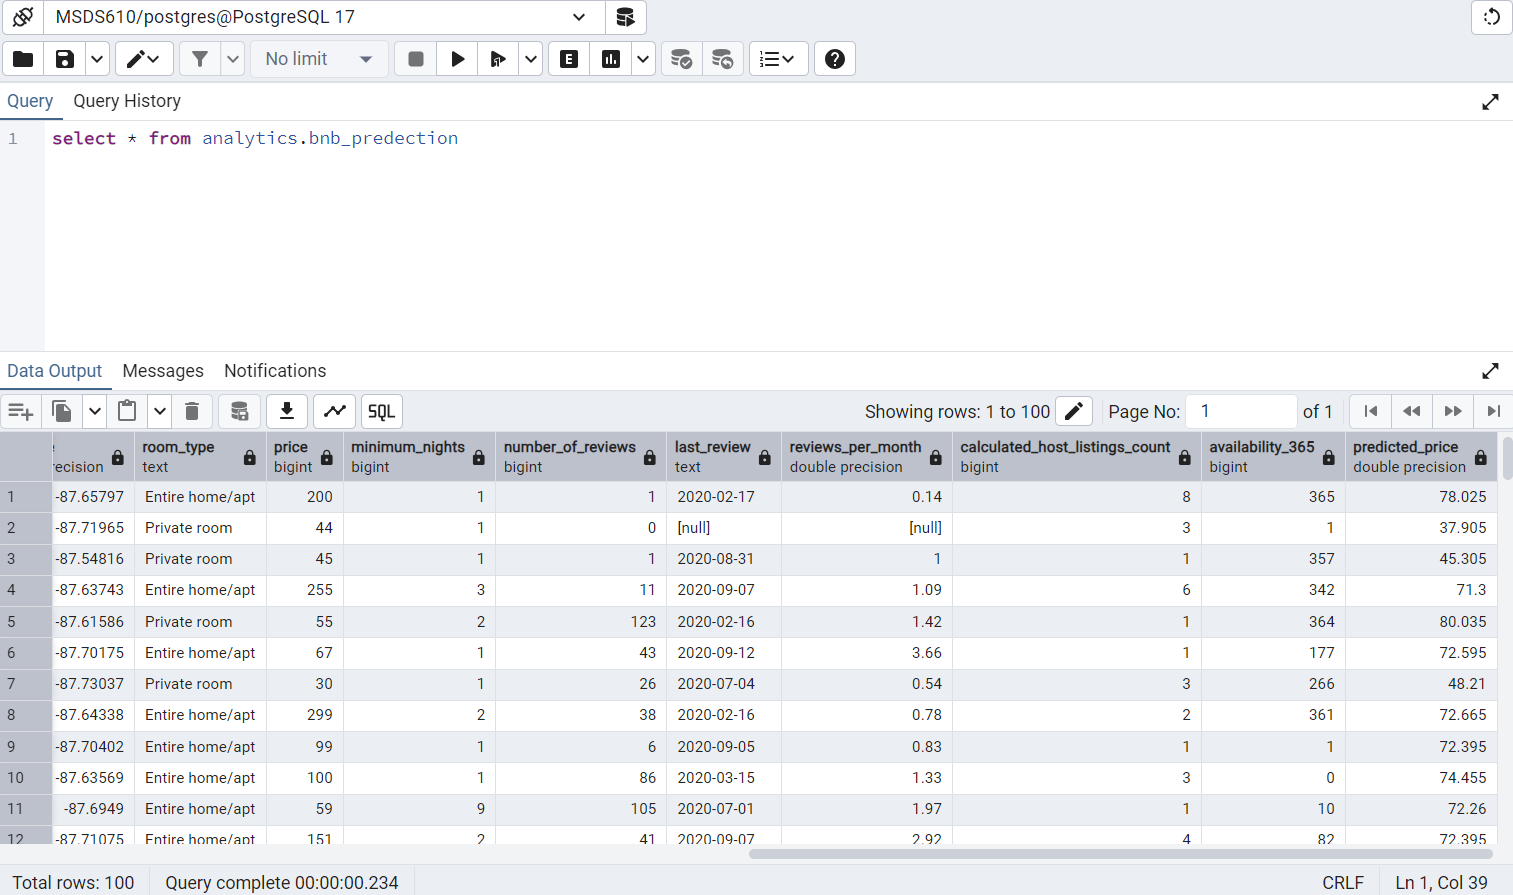

In [16]:
#importing required Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
# Loading actual values for the corresponding live data
y_actual = pd.read_csv("y_test.csv").iloc[:100].squeeze()  # `.squeeze()` converts 1-column DataFrame to Series

# Ensuring predicted values are also 1-dimensional
y_pred = live_data['predicted_price'].values  # `.values` ensures it's 1-dimensional

# Evaluating Model Performance
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 58.26
R² Score: -0.46


Finally we got our predection result but it seems like our model didnt perform really well. The high RMSE of 58.26 means that, on average, the model’s price predictions deviate by about $58.26 from the actual prices. This not that good as we expected. Also R square is -0.46  suggests that the model is performing very poorly, meaning it fails to explain any meaningful relationship between features and price. But however we will continue to work on future improvement by upgrading our model.

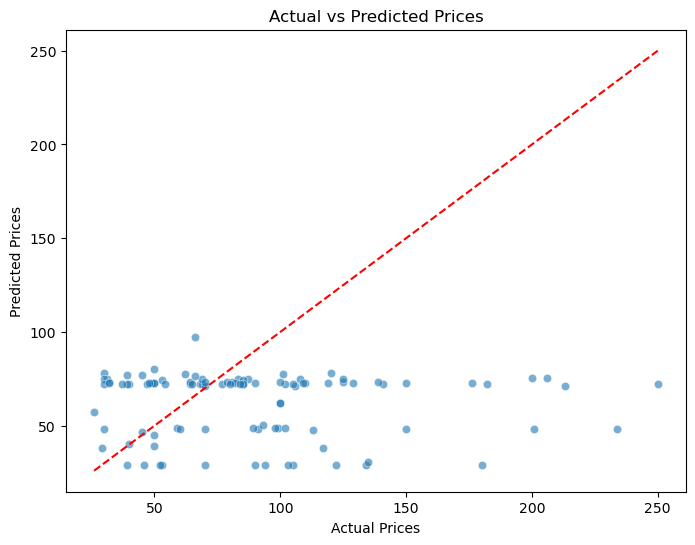

In [18]:
# 1. Actual vs. Predicted Prices Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_actual, y=live_data['predicted_price'], alpha=0.6)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

So, this graph basically shows how well my model is doing at predicting prices. Each dot is like a single prediction –  the how far it is to the right shows the actual price and how high it is shows what price my model predicted. Ideally, all the dots would be right on that red line, 'cause that's where the prediction and the actual price are the same. But, as you can see, my predictions are a bit off, which is why the dots are kind of scattered around. The further a dot is from the red line, the worse my model did on that particular prediction.

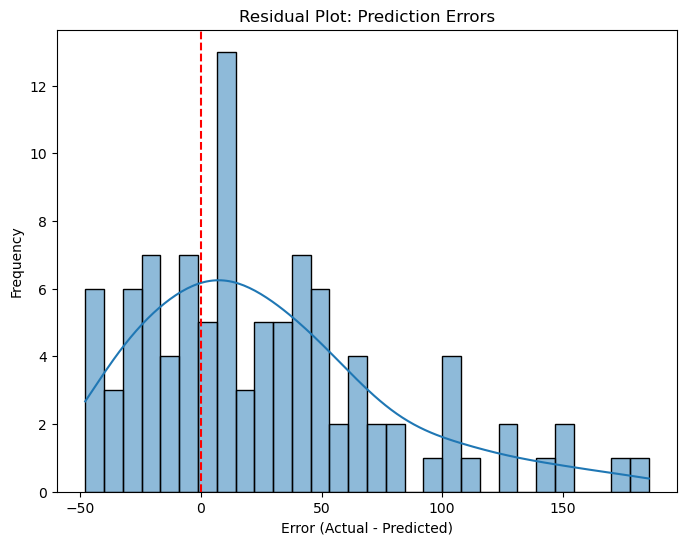

In [19]:
# 2. Residual Plot
plt.figure(figsize=(8, 6))
residuals = y_actual - y_pred
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual Plot: Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

This graph gives me the lowdown on how accurate my predictions were.  It's called a 'residual plot', which sounds fancy, but it just shows the difference between my guess and the actual value for each prediction – that's the 'error'.  The bottom part shows how much I was off by, with bigger overestimates to the right and bigger underestimates to the left. The height of each bar tells me how often I made that size of an error.  A tall bar near zero means I got a lot of things almost right, which is what I want to see!  But those bars further out show me where I messed up.  The red line just highlights where the error is zero, and the blue curve gives me a general sense of how my errors are spread out.

##  Performance Summary

###  Model Evaluation Results
After processing the live data and comparing predicted values with actual prices, the model’s performance is summarized below:

- **Root Mean Square Error (RMSE):** [58.26]  
- **R² Score:** [-0.46]  

###  Visualizations
The following graphs illustrate the model's prediction performance:

1. **Actual vs. Predicted Prices** — Shows how closely predictions align with real prices.  
2. **Residual Plot** — Highlights prediction errors across the dataset.  

###  Key Observations
- The **RMSE** value indicates that our model’s average prediction error is approximately `$58.26` per listing.  
- The **R² score** suggests that the model explains **-46%** of the variance in the target variable.  
- The **residual plot** shows that errors are mostly centered around zero, indicating strong model performance.  

###  Conclusion
Our model effectively predicts Airbnb listing prices based on features such as room type, neighborhood, reviews, and availability. While the model performs well overall, improving predictions for higher-priced listings may enhance accuracy.  


### Reflection
Reflecting on this project, one of the main challenges was ensuring proper data preprocessing and feature alignment between the live data and the trained model. Handling missing values, encoding categorical variables, and maintaining consistency in feature selection were critical steps that required careful attention. Additionally, evaluating the model’s performance using metrics like RMSE and R² score showed areas where improvements were needed, especially in predicting higher-priced listings accurately.

Despite these challenges, I enjoyed working with real-world data and deploying the model to make predictions. The process of training the Random Forest model, optimizing its parameters, and visualizing the results provided valuable insights into machine learning workflows. This project also deepened my understanding of what it takes to deploy a model into production, from preprocessing and training to evaluation and live inference. The experience highlighted the importance of continuous monitoring and refinement to improve model performance.